# Siamese Network with Contrastive Loss on MNIST

This code was modified from the example of a Siamese Network provided in the Keras example directory on Github. The main difference is that we changed the base network to be convolutional. We also sample random pairs per batch instead of training on a fixed set of pairs.

Make sure you've got Tensorflow and Keras installed. (This was tested with Tensorflow 1.0.1 and Keras 2.0.3)

In [1]:
import matplotlib
import matplotlib.pyplot as plt

%matplotlib notebook

from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random as rand
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input, Lambda, Conv2D, Flatten
from keras import optimizers
from keras import backend as K

Using TensorFlow backend.


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# Define data sampling functions

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train.astype('float32'), -1)
x_test = np.expand_dims(x_test.astype('float32'), -1)
x_train /= 255
x_test /= 255
input_shape = (28,28,1)

train_by_class = []
test_by_class = []
for i in range(0,10):
    inds = (y_train == i)
    train_by_class.append(x_train[inds,:,:,:])
    inds = (y_test == i)
    test_by_class.append(x_test[inds,:,:,:])
    
%reset_selective -f x_test
%reset_selective -f x_train

def get_batch_pairs(batch_size=128, pos_only=False, neg_only=False, test=False):
    batch_a = np.zeros((batch_size,)+input_shape )
    batch_b = np.zeros((batch_size,)+input_shape )
    labels = np.random.randint(2, size=(batch_size,))
    img_list = train_by_class
    if test:
        img_list = test_by_class
    if pos_only:
        labels = np.ones((batch_size,))
    elif neg_only:
        labels = np.zeros((batch_size,))
    for i in range(batch_size):
        if labels[i] == 1:
            klass = np.random.randint(10)
            ind_a , ind_b = rand.sample(range(img_list[klass].shape[0]), 2)
            batch_a[i,:,:,:] = img_list[klass][ind_a,:,:,:]
            batch_b[i,:,:,:] = img_list[klass][ind_b,:,:,:]
        else:
            klass_a, klass_b = rand.sample(range(10), 2)
            ind_a = np.random.randint(img_list[klass_a].shape[0])
            ind_b = np.random.randint(img_list[klass_b].shape[0])
            batch_a[i,:,:,:] = img_list[klass_a][ind_a,:,:,:]
            batch_b[i,:,:,:] = img_list[klass_b][ind_b,:,:,:]
    return ([batch_a, batch_b], labels)

def batch_generator(batch_size=128):
    while True:
        yield get_batch_pairs(batch_size)


In [3]:
# dimensionality of feature space:
latent_dim = 2

# some extra operations for our Siamese net:

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.maximum(K.sum(K.square(x - y), axis=1, keepdims=True), K.epsilon()))

def l1_distance(vects):
    x, y = vects
    return K.maximum(K.sum(K.abs(x - y), axis=1, keepdims=True), K.epsilon())


def dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    margin = 1.0
    return K.mean(y_true * K.square(y_pred) +
                  (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))


def create_base_network(input_shape):
    
    net = Sequential()
    net.add(Conv2D(32, (3,3), input_shape=input_shape, activation='relu', strides=(2,2), padding='same'))
    net.add(Conv2D(64, (3,3), activation='relu', strides=(2,2), padding='same'))
    net.add(Conv2D(128, (3,3), activation='relu', strides=(2,2), padding='valid'))
    net.add(Conv2D(128, (3,3), activation='relu', strides=(1,1), padding='same', name='conv4'))
    net.add(Flatten())
    net.add(Dense(256, activation='relu'))
    net.add(Dense(latent_dim, activation=None))
    
    return net


In [4]:
# network definition
base_network = create_base_network(input_shape)

# We use two seperate input layers for the two samples in each pair
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

feature_a = base_network(input_a)
feature_b = base_network(input_b)

# Add a lambda layer to compute distance. Use Euclidean or L1 defined above.
distance = Lambda(euclidean_distance,
                  output_shape=dist_output_shape)([feature_a, feature_b])

model = Model([input_a, input_b], distance)

model.compile(loss=contrastive_loss, optimizer=optimizers.Adam())

In [9]:
# Train!

model.fit_generator(batch_generator(),
                   steps_per_epoch=500,
                   epochs=5)


Epoch 1/5
500/500 [==============================] - 5s - loss: 0.0088     
Epoch 2/5
500/500 [==============================] - 5s - loss: 0.0059     
Epoch 3/5
500/500 [==============================] - 5s - loss: 0.0038     
Epoch 4/5
500/500 [==============================] - 5s - loss: 0.0035     
Epoch 5/5
500/500 [==============================] - 5s - loss: 0.0042     


In [10]:
# compute final accuracy on training and test sets

pred_pos = model.predict(get_batch_pairs(pos_only=True, batch_size=1000)[0])
pred_neg = model.predict(get_batch_pairs(neg_only=True, batch_size=1000)[0])
tr_acc = ((pred_pos < 0.5).sum() + (pred_neg > 0.5).sum()) / 2000.

pred_pos = model.predict(get_batch_pairs(pos_only=True, batch_size=1000, test=True)[0])
pred_neg = model.predict(get_batch_pairs(neg_only=True, batch_size=1000, test=True)[0])
te_acc = ((pred_pos < 0.5).sum() + (pred_neg > 0.5).sum()) / 2000.

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))

* Accuracy on training set: 99.85%
* Accuracy on test set: 98.80%


<IPython.core.display.Javascript object>


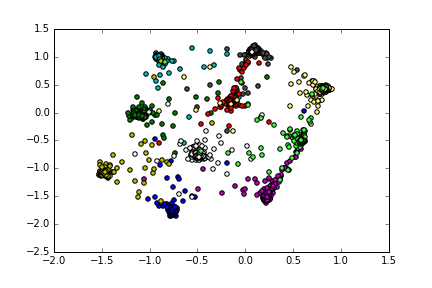

In [12]:
# Now let's plot the learned 2D features of images in the test set.

feat_by_class = []
for val in test_by_class:
    feat_by_class.append(base_network.predict(val, batch_size=100))

plt.figure()
colors = ['b', 'c', 'g', [0.3, 0.3, 0.3], 'm', 'r', 'y', [1., 1., 0.5], 'w', [0.25, 1.0, 0.25]]
for i, embs in enumerate(feat_by_class):
    plt.scatter(embs[:,0],embs[:,1], c=colors[i])

<IPython.core.display.Javascript object>


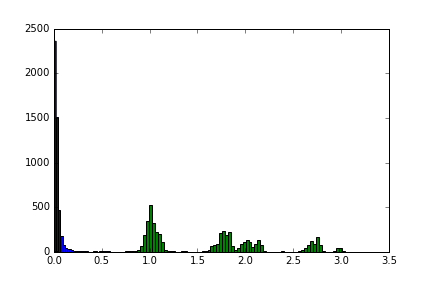

In [13]:
# Now let's plot the distributions of positive-pair and negative-pair distances in the test set.

plt.figure()
out = plt.hist(model.predict(get_batch_pairs(test=True, pos_only=True, batch_size=5000)[0]), bins=100)
out = plt.hist(model.predict(get_batch_pairs(test=True, neg_only=True, batch_size=5000)[0]), bins=100)